# Image segmentation with NCUT
# Assignment 4 - Alessio Cascione

The notebook is divided into three main sections: the first one illustrates the code and the choice of evaluation metric for the segmentation; the second reports mean evaluation scores for each thematic class and two examples of well segmented images; the brief third one presents short comments on the overall results.

Libraries needed for the assignment completion are installed and/or directly imported. The main reference library is *skimage*, both for the superpixel algorithm and for N-cut.

An auxiliary function for image reading is defined below along with a function performing in sequences the needed steps to compute superpixels and defining images' segments starting from the graph built upon superpixels.



### Section 1 - Code and variation of information

In [ ]:
!pip install scikit-image -U
!pip install Pillow==9.0.0
!pip install colordict

In [ ]:
import os
import skimage
import numpy as np
import pandas as pd
import cv2

from skimage import data, segmentation, color, graph, io, metrics
from matplotlib import pyplot as plt
from PIL import Image
from colordict import ColorDict
from random import shuffle



In [ ]:
#checking skimage version ('0.20.0 is necessary for proper runnign fo the code)
print('The scikit-image version is {}.'.format(skimage.__version__))

The scikit-image version is 0.20.0.


In [ ]:
#auxiliary function simply used for
def get_image(ref_string):
  image = cv2.imread(ref_string)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert it to RGB
  return image


In [ ]:
images = os.listdir('MSRC_ObjCategImageDatabase_v1') #get all files

colors = list(ColorDict().values()) #define colors to use for the overlay final segmentation
shuffle(colors)

raw_strings = sorted([img for img in images if img[-6:-4] != 'GT'])[:-2] # get images names
GT_strings = sorted([img for img in images if img[-6:-4] == 'GT']) #get GT names
Class = sorted([int(img[0]) for img in images if img[-6:-4] == 'GT' ]) #get thematic class

df = pd.DataFrame(data = {'raw_strings' : raw_strings, 'GT_strings' : GT_strings, 'Class' : Class })


evalutate_thematic_class() uses SLIC approach presented in *skimage* in order to define superpixels, applying k-means using RGB colors and <x,y> coordinates to merge pixels together.

Then a graph built on top of superpixeled images is obtained and N-cut is then applied on it to define the segmented image.

The function is assumed to consider one thematic class at time from the dataframe, returning for each image in a particular thematic class its superpixels representation, the respective segmented version and the Variation of Information value computed between the two.

In [ ]:
def evaluate_thematic_class(class_label):
  data_frame = df[df['Class'] == class_label]
  superpixels_images = []
  segmented_images = []
  VI = []


  for raw_string, GT_string in zip(data_frame['raw_strings'], data_frame['GT_strings']):
    image = cv2.imread('MSRC_ObjCategImageDatabase_v1/' + raw_string)  #import image
    GT = cv2.imread('MSRC_ObjCategImageDatabase_v1/' + GT_string) #import image

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert it to RGB
    GT = cv2.cvtColor(GT, cv2.COLOR_BGR2RGB)#convert it to RGB

    #extract superpixles using k-means on colors + <x,y> coordinates
    superpixels_labels = segmentation.slic(image, compactness=40, n_segments=600,
                            start_label=1,  max_num_iter=40)

    out_superpixels = color.label2rgb(superpixels_labels, image, kind='avg', bg_label=0)

    superpixels_images.append(out_superpixels)


    g = graph.rag_mean_color(image, superpixels_labels, mode='similarity')
    labels_graph = graph.cut_normalized(superpixels_labels, g)

    #overlay is used instead of avg as "kind" parameter in order to differentiate more sharply
    #between segmented regions with different colors
    out_graph = color.label2rgb(labels_graph, image = None,
                                kind='overlay', colors = colors, bg_color = (0,0,0))

    segmented_images.append(out_graph)

    var_inf = metrics.variation_of_information(image0=GT, image1=out_graph.astype(int))

    VI.append(var_inf)

  return  superpixels_images, segmented_images, VI


In [ ]:
superpixels_images = []
segmented_images = []
VI = []

In [ ]:
for i in df['Class'].unique():
  superpixels, segmented, vi = evaluate_thematic_class(i)
  superpixels_images += superpixels
  VI += vi

df['superpixels'] = superpixels_images
df['segmented_images'] = segmented_images
df['VI'] = VI

The accuracy metric chosen for segmentation comparison is Variation of Information: given a ground-truth image X and its segmented counterpart Y, then the Variation of Information between the two will be:

VI(X,Y) = H(X|Y) + H(Y|X)

where H(X|Y) is the conditional entropy of the ground-truth with respect to the segmentation obtained and H(Y|X) the opposite.

Roughly quoting the original [paper](https://www.sciencedirect.com/science/article/pii/S0047259X06002016) which introduced the metric:

> The first term measures the amount of information about X that we loose, while the second measures the amount of information about Y that we have to gain, when going from clustering X to clustering Y (p. 879-880).

Variation of information was defined in order to compare different clustering partitions over the same data-set: in this case the comparison is made over two different segmentations (the one obtained and the ground-truth), as reported in *skimage* [documentation](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.variation_of_information):

> If X is the ground-truth segmentation, then H(X|Y) can be interpreted as the amount of under-segmentation and H(Y|X) as the amount of over-segmentation. In other words, a perfect over-segmentation will have H(X|Y) = 0 and a perfect under-segmentation will have H(Y|X) = 0.

Therefore, the evaluation performances consider as the best identified thematic group the one having the lowest average variation of information score across all images.

### Section 2 - Results and well segmented examples

In [ ]:
thematic_VI = []

for i in df['Class'].unique():
  curr_VI = df[df['Class'] == i]['VI']
  mean_VI = 0
  for arr in curr_VI:
    mean_VI += arr.sum()
  thematic_VI.append(mean_VI / len(curr_VI))


summary_table = pd.DataFrame(data = {'Class' : df['Class'].unique(), 'AVG_VI' : thematic_VI })

In [ ]:
summary_table

,Class,AVG_VI
0,1,2.300902
1,2,3.945857
2,3,3.769030
3,4,3.285931
4,5,3.374222
5,6,4.249444
6,7,4.174214
7,8,4.734929


The best identified thematic group was the first one, the worst the eight one. Two well identified images, respectively coming from the first and fourth groups, are presented below as examples of good segmentations.

The first example comes from the first class, , with H(GT|segmented_image) = 2.73403139 and H(segmented_image|GT) = 0.36890934


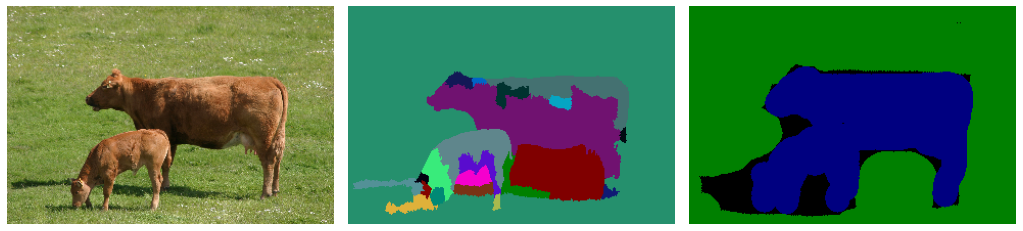

The second example comes form the fourth class with H(GT|segmented_image) =  2.64938897 and H(segmented_image|GT) = 0.55273638. Similar comments regarding oversegmentation of the main portion can be applied, noticing how the main object is well separated form the rest but it is over-separated into smaller regions comprising the its main structure.

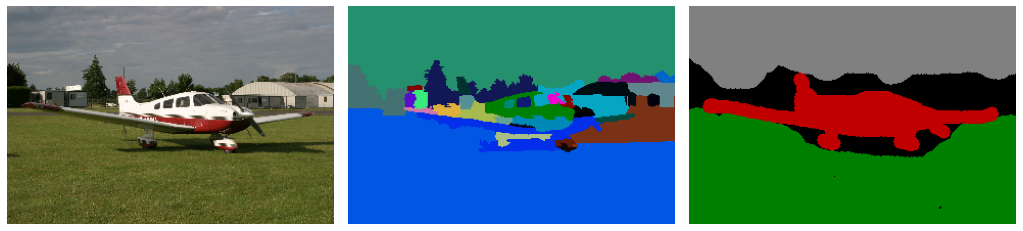

### Section 3 - Brief final comments

As a final consideration, it can be noticed how the N-cut algorithm simply partitions the image without necessarily associating a unique semantic class to each segment. Semantic groups are identified with different colors in the ground truth segmentation of the data-set wheras N-cut does not express any semantic information regarding its regions.

In this sense, pixel-to-pixel kind of comparisons do not lead to optimal evaluation in this segmentation context (shapes and region borders could be correctly identified by N-cut, but they could get assigned a non-correspoding color with respect to the relevant semantic class on hand, therefore negatively influencing scores and metrics taking this into account). On the other hand a metric such as Variation of information seems to give us more reliable results in this sense, measuring the overall similarity of two partitions without directly checking pixels with pixels colors: if other metrics were to be used, an approach for the right assignment of colors to each segments should be introduced to deal with the issue.


An additional problem is related to the tendency of N-cut of segmenting in a finer-grain compared to the actual ground-truth: the same semantic area tends to be split into numerous subsections, a tendency that seem to be present, even if in lower degree, when using broader and less compact superpixels.

In the end, as it could be intuitively reasonable, thematic classes belonging to complex objects such as bycicles and cars are segmented in a generally less desirable way when compared to results for trees and animals over a green background.


In order to perform the assignment and for the sake of completness, also *Matlab* library was explored for the solution: it implemenst the same SLIC approach for superpixels and allows to use N-cut as segmentation strategy. *skimage* library seemed to give a more stable control on paramters related to superpixel images and also easier for an overall use, motivating the choice of using this last implementation as solving approach.